# Introduction and Background

A method for calculating pressure drop in CMF (Coriolis Mass Flow Meters) was developed by Tony Pankratz and Gary Pawlas in 1995. This method improved upon the previous method of calculating pressure drop in the meters by improving accuracy of pressure drop in gaseous process fluids. 

A CMF meter can be though of as comprised of 3 major components:
1. Straight tube sections
2. Curved tube sections (bends)
3. Flanges/manifolds
Each of these components contributes to pressure drop. Therefore, each term is represented in the pressure drop equation derived in this paper

The main equation used for calculating pressure drop, or $\Delta P$ is Eq 1:
<img src='imgs/eq1_annotated.png' alt='Eq 1' style='height: 170px;'/>

This equation is only dependent on 3 things:
1. meter geometry
2. fluid properties
3. tube roughness

## Variable/Equation Definitions and Sources

A summary of the variables and where they come from are in the following table:

<img src='imgs/variable_table.png' alt='Variable Table' style='width: 600px;' />

And a list of the equations used:
<img src='imgs/all_eqns.png' style='height: 500px;'/>

I won't go into all of the details of these equations since their derivation isn't the focus of this notebook. The details are in [Pressure Drop Prediction of Coriolis Mass Flowmeters](pd_paper.pdf)

## Summary of Procedure:

* **Step 1**: Collect and plot Pressure Drop ($\Delta P$) vs Mass Flow Rate ($\dot{m}$) data
* **Step 2**: Obtain a curve fit equation for this $\Delta P$ vs $\dot{m}$ plot
* **Step 3**: Calculate $K_M$ using Eq. 8 and $\Delta P$ from Step 2
* **Step 4**: Plot $K_M$ vs Re values
* **Step 5**: Curve fit the plot from Step 4
* **Step 6**: Use Eq 1 and all of the other calculated components to calculate $\Delta P$

# Working Through Sample CMF100 Data

The data I'm going to use to set up my functions and work through an example comes from the paper mentioned above. It was collected on a CMF100 running water.

### Import Libraries

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Import Sample Data

In [122]:
DATA_PATH = 'data\\cmf100_example_data.csv'

In [123]:
data = pd.read_csv(DATA_PATH)
data

,mdot_lb_min,dp_psi
0,13,0.05
1,40,0.19
2,60,0.32
3,80,0.49
4,111,0.82
5,120,0.93
6,140,1.19
7,160,1.48
8,180,1.81
9,210,2.35


## Step 1: pressure drop vs mass flow rate

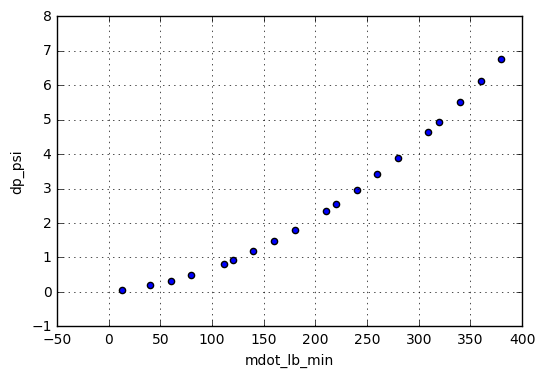

In [124]:
data.plot(kind='scatter',x='mdot_lb_min',y='dp_psi',grid=True)


## Step 2: Fit a Curve to the Data from Step 1

To fit this curve, we will use a least squares regression (a second order polynomial with a y-intercept of zero). The coefficients $B_1$ and $B_2$ in the following template equation will be given by this curve fit:

$$\Delta P = B_1\cdot \dot{m}^2+B_2\cdot\dot{m}+0 $$

In [125]:
from scipy.optimize import curve_fit

In [126]:
def dP_curve_fit(m_dot, B1, B2):
    return B1*(m_dot**2)+B2*m_dot

In [127]:
xdata = data['mdot_lb_min']
ydata = data['dp_psi']
xdata_scaled = xdata / 100
pop_dp_scaled, pconv_dp = curve_fit(dP_curve_fit, xdata_scaled, ydata)
pop_dp_scaled

array([ 0.38584943,  0.30901961])

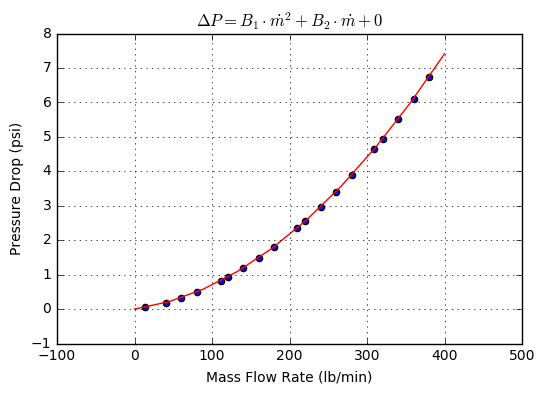

In [128]:
B1 = pop_dp_scaled[0] / (100**2)
B2 = pop_dp_scaled[1] / 100

plt.scatter(xdata, ydata, label='Experimental Data')
x_in = np.linspace(0,400,10)
plt.plot(x_in, dP_curve_fit(x_in, B1, B2), 'r-', label='dP Curve Fit')
plt.xlabel('Mass Flow Rate (lb/min)')
plt.ylabel('Pressure Drop (psi)')
plt.title('$\Delta P = B_1\cdot \dot{m}^2+B_2\cdot\dot{m}+0 $')
plt.grid(True)

In [129]:
def dP_curve_coefs(m_dot, dp_exp):
    xdata = m_dot
    ydata = dp_exp
    xdata_scaled = xdata / 100
    pop_dp_scaled, pconv_dp = curve_fit(dP_curve_fit, xdata_scaled, ydata)
    B1 = pop_dp_scaled[0] / (100**2)
    B2 = pop_dp_scaled[1] / 100
    return [B1, B2]

In [130]:
dP_curve_coefs(data['mdot_lb_min'], data['dp_psi'])

[3.8584942712388961e-05, 0.0030901961122250638]

## Step 3: Calculate $K_M$

We are going to use Eq 8 and $\Delta P$ from the previous step to calculate $K_M$. Eq 8 is as follows:
$$K_M=\frac{2\Delta P}{\rho\cdot V^2}-f\frac{L}{D_H}-\left(n_{bends}\cdot\frac{angle_{bend}}{90.0^{\circ}}\cdot K_B\right)$$

In [131]:
import math
rho = 1000 # Kg/m^3

# Calculate tube cross-sectional area
Id = .0164338 # m
A = math.pi *(Id/2)**2
Dh = Id
mu = 1e-3 # cP, viscosity of water

data_new = data.copy()
## Use the previous equation to add data to dp_psi column
data_new['dp_psi'] = dP_curve_fit(data_new['mdot_lb_min'], B1, B2)
## Adding velocity term
data_new['V'] = ((data_new['mdot_lb_min']/2)/(rho*A))*.024819

# Reynolds number
data_new['Re'] = (rho*data_new['V']*Dh / mu)*(1/3.28)

# friction factor, f (Haaland)
epsilon = 1.524e-6 # m (5e-6 ft), relative roughness
data_new['f_Haaland'] = (-1.8*np.log10((6.9/data_new['Re'])+((epsilon/Dh)/3.7)**1.11))**-2

# K_B
x = .0508/Dh # R/D_h term, R=bend radius (from spreadsheet)
data_new['K_B'] = (1e-4)*(x**4)-(3.5e-3)*(x**3)+3.18e-2*(x**2)-.1382*x+.3288

#K_M
data_new['K_M'] = 74179.2*(2*data_new['dp_psi']/(rho*(data_new['V']**2))) - (data_new['f_Haaland']*(.966216/Dh)) - (2*(135/90)*data_new['K_B'])

In [132]:
data_new

,mdot_lb_min,dp_psi,V,Re,f_Haaland,K_B,K_M
0,13,0.046693,0.760557,3810.622376,0.041102,0.11121,9.225574
1,40,0.185344,2.340175,11724.991927,0.029684,0.11121,2.942158
2,60,0.324318,3.510263,17587.487890,0.026734,0.11121,1.999407
3,80,0.494159,4.680351,23449.983853,0.024911,0.11121,1.548482
4,111,0.818417,6.493987,32536.852596,0.023068,0.11121,1.189240
5,120,0.926447,7.020526,35174.975780,0.022662,0.11121,1.122600
6,140,1.188892,8.190614,41037.471743,0.021894,0.11121,1.008307
7,160,1.482206,9.360701,46899.967706,0.021264,0.11121,0.925776
8,180,1.806387,10.530789,52762.463669,0.020733,0.11121,0.863944
9,210,2.350537,12.285921,61556.207614,0.020074,0.11121,0.796425


## Step 4: Plot $K_M$ vs Re

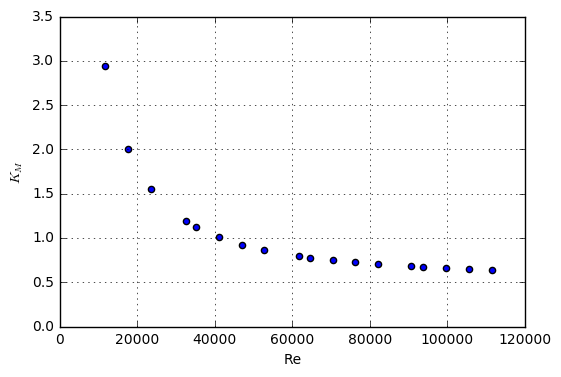

In [133]:
plt.scatter(data_new['Re'][1:],data_new['K_M'][1:])
plt.ylim([0,3.5])
plt.xlabel('Re')
plt.ylabel('$K_M$')
plt.grid(True)

## Step 5: Curve fit data from previous step

The equation for the curve will be in this format:
$$K_M=A_1+A_2\cdot e^{-A_3Re}+A_4\cdot e^{-A_5Re}$$

I will use the curve fit tool from scipy (the paper used Table Curve 2.0 to fit the curve).

In [134]:
from scipy.optimize import curve_fit

In [135]:
def func(Re, A1, A2, A3, A4, A5):
    return A1 + A2*np.exp(-A3*Re) + A4*np.exp(-A5*Re)

In [136]:
xdata = data_new['Re'][1:]
xdata_scaled = xdata*10**-4
ydata = data_new['K_M'][1:]
popt_scaled, pcov = curve_fit(func, xdata_scaled, ydata)
popt_scaled

array([ 0.61761182,  7.48184493,  1.57323481,  1.76609387,  0.37276489])

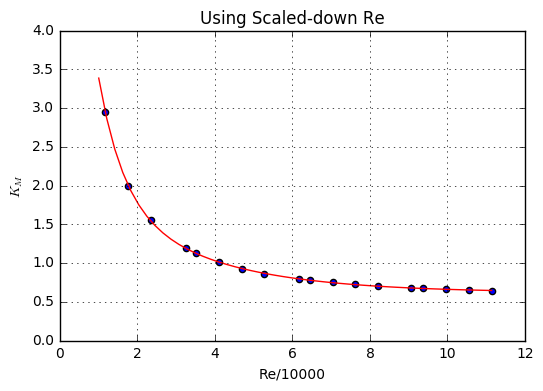

In [137]:
plt.scatter(xdata_scaled,ydata)
x_in = np.linspace(1,xdata_scaled.max(),50)
plt.plot(x_in, func(x_in, *popt_scaled), 'r-')
plt.xlabel('Re/10000')
plt.ylabel('$K_M$')
plt.title('Using Scaled-down Re')
plt.grid(True)

In [138]:
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
print('A1 = {a1}\nA2 = {a2}\nA3 = {a3}\nA4 = {a4}\nA5 = {a5}\n'.format(a1=popt_scaled[0],a2=popt_scaled[1], \
                                                                           a3=popt_scaled[2], a4=popt_scaled[3], \
                                                                           a5=popt_scaled[4]))

A1 = 0.6176118175953003
A2 = 7.481844931364555
A3 = 1.5732348098480955
A4 = 1.766093871168272
A5 = 0.3727648890398728



## Step 6: Feed $K_m$ back into Original Equation

The original equation for predicting pressure drop was:
$$\Delta P = \frac{\rho\cdot V^2}{2}\left[f\cdot\frac{L}{D_H} + \left(n_{bends}\cdot \frac{angle_{bend}}{90.0}\right)\cdot K_B+K_M\right]$$

As a refresher of where all of these variables come from:
$$\rho\text{ is given}$$
$$\dot{m}\text{ is given}$$
$$V = \frac{\frac{\dot{m}}{2}}{\rho\cdot A}$$
$$A\text{ is given}$$
$$D_H=\frac{4A}{WP}(=ID\text{ for circular tubes})$$
$$f= \left[ -1.8\log \left( \frac{6.9}{Re}+ \left( \frac{\frac{\epsilon}{D_H}}{3.7} \right)^{1.11} \right) \right]^{-2}$$
$$L\text{ is given}$$
$$n_{bends}\text{ is given}$$
$$angle_{bend}\text{ is given}$$
$$K_B=1\times 10^{-4} \left[ \frac{R}{D_H} \right] ^4-3.5 \times 10^{-3} \left[ \frac{R}{D_H} \right]^3 +3.18\times 10^{-2}\left[\frac{R}{D_H}\right]^2-0.1382\left[\frac{R}{D_H}\right]+0.3288$$
$$K_M=A_1+A_2\cdot e^{-A_3\text{Re}}+A_4\cdot e^{-A_5\text{Re}}$$

### Define functions for each of these variables

In [139]:
def V_out(m_dot, rho, A):
    '''
    m_dot comes in as lb/min, need to convert to    ft/s
    '''
    return ((m_dot/2)/(rho*A))*.024797

def A_out(ID):
    return math.pi*((ID/2)**2)

def D_H(ID, WP=1, circular=True):
    if(circular):
        return ID
    else:
        A = A_out(ID)
        return (4*A)/WP

def f_out(Re, Dh, e=1.524e-6):
    return (-1.8*np.log10((6.9/Re)+((e/Dh)/3.7)**1.11))**-2

def K_B(R, Dh):
    x = R / Dh
    return (1e-4)*(x**4)-(3.5e-3)*(x**3)+3.18e-2*(x**2)-.1382*x+.3288

def K_M(Re, A1, A2, A3, A4, A5):
    return A1 + A2*np.exp(-A3*Re) + A4*np.exp(-A5*Re)

def Re_out(rho, V, Dh, mu):
    return (rho*V*Dh / mu)*(1/3.28)
#     return ((rho*V*Dh)/mu)*(1/3.28)

def dP(rho, V, L, f, n_bends, angle_bend, Kb, Km):
    return (rho*(V**2)/(2*3.28**2))*(f*(L/Dh) + (n_bends*angle_bend/90)*Kb +Km)

In [140]:
def generate_pd_df(rho, m_dot, mu, ID, L, n_bends, angle_bend, R, A1, A2, A3, A4, A5):
    A = A_out(ID)
    Dh = D_H(ID)
    new_df = pd.DataFrame(columns=['mdot_lb_min','V','Re','f_Haaland','K_B','K_M','dp_Pa', 'dp_psi'])
    new_df['mdot_lb_min'] = m_dot
    new_df['V'] = new_df['mdot_lb_min'].apply(lambda x: V_out(x, rho, A))
    new_df['Re'] = new_df['V'].apply(lambda x: Re_out(rho, x, Dh, mu))
    new_df['f_Haaland'] = new_df['Re'].apply(lambda x: f_out(x, Dh))
    new_df['K_B'] = K_B(R, Dh)
    new_df['K_M'] = new_df['Re'].apply(lambda x: K_M(x/10000, A1, A2, A3, A4, A5))
    new_df['dp_Pa'] = dP(rho, new_df['V'], L, new_df['f_Haaland'], n_bends, angle_bend, new_df['K_B'], new_df['K_M'])
    new_df['dp_psi'] = new_df['dp_Pa']*(1.45038e-4)
    return new_df

In [141]:
rho = 1000 # kg/m^3
mu = 1e-3 # Pa*s
ID = .0164338 # m
L = .966216 # m
n_bends = 2
angle_bend = 135 # deg
R = .0508 # m
A1 = popt_scaled[0]
A2 = popt_scaled[1]
A3 = popt_scaled[2]
A4 = popt_scaled[3]
A5 = popt_scaled[4] # scaled for Re/10000

dP_df = generate_pd_df(rho, data_new['mdot_lb_min'], mu, ID, L, n_bends, angle_bend, R, A1, A2, A3, A4, A5)
dP_df

,mdot_lb_min,V,Re,f_Haaland,K_B,K_M,dp_Pa,dp_psi
0,13,0.759883,3807.244573,0.041114,0.11121,6.260393,241.825630,0.035074
1,40,2.338101,11714.598687,0.029691,0.11121,2.943534,1276.135337,0.185088
2,60,3.507151,17571.898030,0.026740,0.11121,2.006404,2236.407746,0.324364
3,80,4.676202,23429.197373,0.024916,0.11121,1.542631,3395.563339,0.492486
4,111,6.488230,32508.011355,0.023073,0.11121,1.188286,5631.659663,0.816805
5,120,7.014303,35143.796060,0.022667,0.11121,1.123826,6379.948939,0.925335
6,140,8.183353,41001.095403,0.021898,0.11121,1.012475,8196.648205,1.188825
7,160,9.352404,46858.394746,0.021268,0.11121,0.930226,10220.768453,1.482400
8,180,10.521454,52715.694089,0.020737,0.11121,0.866998,12449.871643,1.805704
9,210,12.275030,61501.643104,0.020077,0.11121,0.796470,16180.072507,2.346725


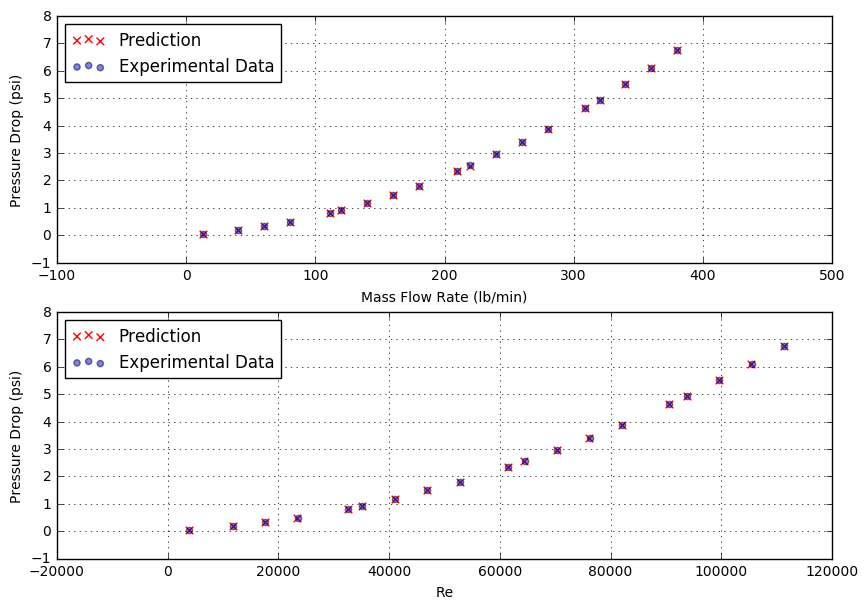

In [142]:
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(2,1,1)
ax1.scatter(dP_df['mdot_lb_min'], dP_df['dp_psi'], c='r', marker='x', s=30, label='Prediction')
ax1.scatter(data_new['mdot_lb_min'], data_new['dp_psi'], label='Experimental Data',alpha=0.5)
plt.grid(True)
plt.xlabel('Mass Flow Rate (lb/min)')
plt.ylabel('Pressure Drop (psi)')
plt.legend(loc=2)

ax2 = fig.add_subplot(2,1,2)
ax2.scatter(dP_df['Re'], dP_df['dp_psi'], c='r', marker='x', s=30, label='Prediction')
ax2.scatter(data_new['Re'], data_new['dp_psi'], label='Experimental Data', alpha=0.5)
plt.grid(True)
plt.xlabel('Re')
plt.ylabel('Pressure Drop (psi)')
plt.legend(loc=2)

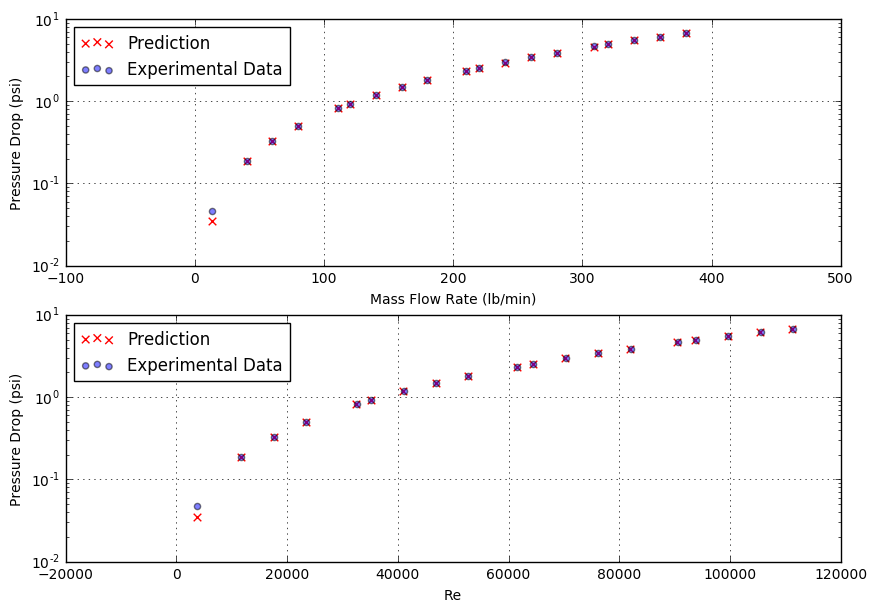

In [143]:
fig = plt.figure(figsize=(10,7))

ax1 = fig.add_subplot(2,1,1)
ax1.scatter(dP_df['mdot_lb_min'], dP_df['dp_psi'], c='r', marker='x', s=30, label='Prediction')
ax1.scatter(data_new['mdot_lb_min'], data_new['dp_psi'], label='Experimental Data', alpha=0.5)
ax1.set_yscale('log')
plt.grid(True)
plt.xlabel('Mass Flow Rate (lb/min)')
plt.ylabel('Pressure Drop (psi)')
plt.legend(loc=2)

ax2 = fig.add_subplot(2,1,2)
ax2.scatter(dP_df['Re'], dP_df['dp_psi'], c='r', marker='x', s=30, label='Prediction')
ax2.scatter(data_new['Re'], data_new['dp_psi'], label='Experimental Data', alpha=0.5)
ax2.set_yscale('log')
plt.grid(True)
plt.xlabel('Re')
plt.ylabel('Pressure Drop (psi)')
plt.legend(loc=2)

## Scaling Coefficients for $K_M$

Currently, I have a scaling factor in my $K_M$ equation. I had to divide Re by 10000 in order to get the curve fitting to work. Now, I will attempt to scale the coefficients so that I can feed in my non-scaled Re numbers.

The equation I used in the curve fit was:
$$K_M=A_1+A_2\cdot e^{-A_3\frac{\text{Re}}{10000}}+A_4\cdot e^{-A_5\frac{\text{Re}}{10000}}$$

Therefore, in order to scale my coefficients so I can feed in raw Re values, I'll make the following conversions:
$$A_3 \rightarrow \frac{A_3}{10000}$$
$$A_5 \rightarrow \frac{A_5}{10000}$$

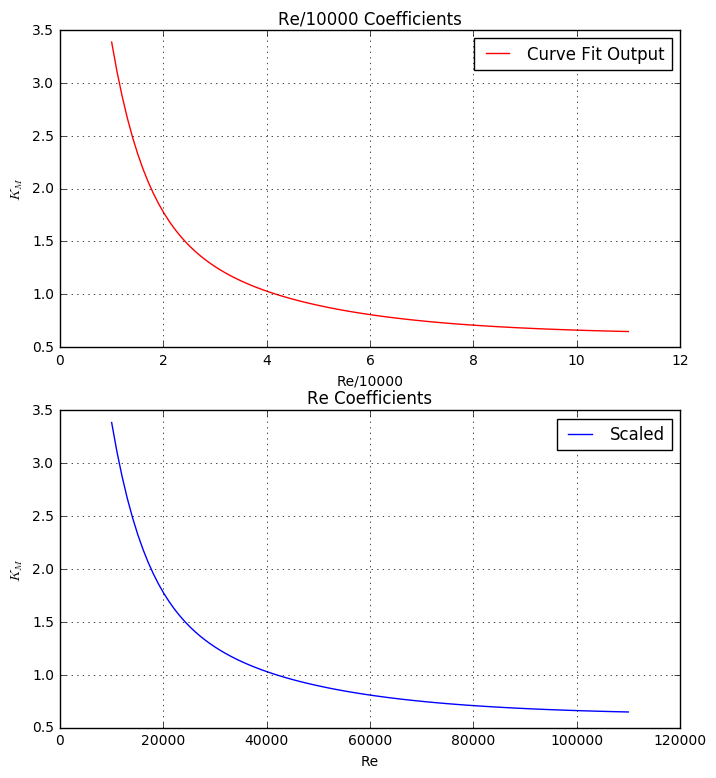

In [144]:
x = np.linspace(10000,110000,100)

A1 = popt_scaled[0]
A2 = popt_scaled[1]
A3 = popt_scaled[2]
A4 = popt_scaled[3]
A5 = popt_scaled[4]

A3_scaled = A3 / 10000
A5_scaled = A5 / 10000

fig = plt.figure(figsize=(8,9))

ax1 = fig.add_subplot(2,1,1)
ax1.plot(x/10000, K_M(x/10000, A1, A2, A3, A4, A5), 'r-', label='Curve Fit Output')
plt.xlabel('Re/10000')
plt.ylabel('$K_M$')
plt.grid(True)
plt.title('Re/10000 Coefficients')
plt.legend()

ax1 = fig.add_subplot(2,1,2)
ax1.plot(x, K_M(x, A1, A2, A3_scaled, A4, A5_scaled), 'b-', label='Scaled')
plt.xlabel('Re')
plt.ylabel('$K_M$')
plt.grid(True)
plt.title('Re Coefficients')
plt.legend()

In [145]:
y_curve_fit = K_M(x/10000, A1, A2, A3, A4, A5)
y_scaled = K_M(x, A1, A2, A3_scaled, A4, A5_scaled)
(1/len(y_curve_fit))*sum((y_curve_fit-y_scaled)**2)

1.0230539864584998e-32

Cool, it looks like this is an effective way to scale the coefficients to handle raw Re values. The next step will be to generate a function to output $A_1$ through $A_5$

## Generating a function for generating $A_1$ through $A_5$

In [146]:
from scipy.optimize import curve_fit

def func(Re, A1, A2, A3, A4, A5):
    return A1 + A2*np.exp(-A3*Re) + A4*np.exp(-A5*Re)

def coefs_out(Re, Km):
    xdata = Re[1:]
    xdata_scaled = xdata*10**-4
    ydata = Km[1:]
    popt_scaled, pcov = curve_fit(func, xdata_scaled, ydata)
    A1 = popt_scaled[0]
    A2 = popt_scaled[1]
    A3 = popt_scaled[2] / 10000
    A4 = popt_scaled[3]
    A5 = popt_scaled[4] / 10000
    return [A1, A2, A3, A4, A5]

In [147]:
[A1, A2, A3, A4, A5] = coefs_out(data_new['Re'], data_new['K_M'])

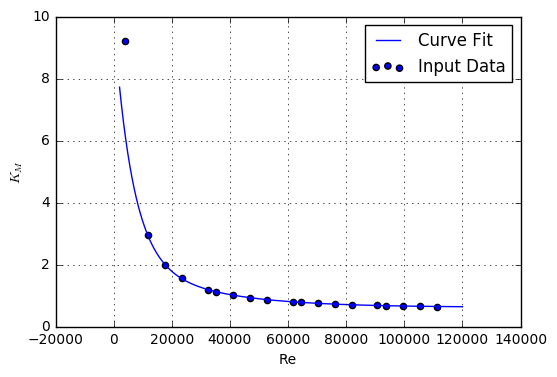

In [148]:
x_in = np.linspace(2000, 120000, 1000)
plt.scatter(data_new['Re'], data_new['K_M'], label='Input Data')
plt.plot(x_in, func(x_in, A1, A2, A3, A4, A5), label='Curve Fit')
plt.grid(True)
plt.xlabel('Re')
plt.ylabel('$K_M$')
plt.legend()

In [149]:
print('A1 = {a1}\nA2 = {a2}\nA3 = {a3}\nA4 = {a4}\nA5 = {a5}\n'.format(a1=A1, a2=A2, a3=A3, a4=A4, a5=A5))

A1 = 0.6176118175953003
A2 = 7.481844931364555
A3 = 0.00015732348098480956
A4 = 1.766093871168272
A5 = 3.727648890398728e-05



# Interactive Pressure Drop Prediction

Now that I've shown that these functions all work and return expected values, it's time to fine tune the model so that the predicted values line up better with the experimental values. The only values that will require tweaking are the coefficients for the $K_M$ equation ($A_1$ through $A_5$). To make it easier to tweak and observe the results, I'm going to add interactive controls to adjust these values. The starting values will be what `coefs_out` outputs.

In [150]:
def plot_dP_adj(a1, a2, a3, a4, a5):
    m_dot = np.linspace(10,400,200)
    rho = 1000 # kg/m^3
    ID = .0164338 # m
    A = A_out(ID)
    mu = 1e-3 # Pa*s
    n_bends = 2
    angle_bend = 135 # deg
    R = .0508 # m
    Dh = D_H(ID)
    V = V_out(m_dot, rho, A)
    Re = Re_out(rho, V, Dh, mu)
    f = f_out(Re, Dh)
    Km = K_M(Re, a1, a2, a3, a4, a5)
    Kb = K_B(R, Dh)
    dP = (rho*(V**2)/(2*3.28**2))*(f*(L/Dh) + (n_bends*angle_bend/90)*Kb +Km)*(1.45038e-4) # psi
#     plt.plot(Re, dP,'r-')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('Re')
#     plt.ylabel('Pressure Drop (psi)')
#     plt.xlim([10**3, 10**6])
#     plt.ylim([10**-2, 10**2])
    return Re, dP

def dP(rho, V, L, f, n_bends, angle_bend, Kb, Km, Dh):
    return (rho*(V**2)/(2*3.28**2))*(f*(L/Dh) + (n_bends*angle_bend/90)*Kb +Km)

def generate_dP_curve(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R, dP_df, A1, A2, A3, A4, A5):
    A = A_out(ID)
    mdot_in = np.linspace(m_dot.min(), m_dot.max(), 1000)
    V = V_out(m_dot, rho, A)
    Dh = D_H(ID)
    Re = Re_out(rho, V, Dh, mu)
    f = f_out(Re, Dh)
    Kb = K_B(R, Dh)
    Km = K_M(Re, A1, A2, A3, A4, A5)
    dP_out = dP(rho, V, L, f, n_bends, angle_bend, Kb, Km, Dh)*(1.45038e-4)
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.scatter(dP_df['Re'], dP_df['K_M_1'], c='b', label='Experimental Data')
    x_in = np.linspace(1, 1e8, 100000)
#     ax1.plot(dP_df['Re'], K_M(dP_df['Re'], A1, A2, A3, A4, A5), 'r-')
    ax1.plot(x_in,K_M(x_in, A1, A2, A3, A4, A5), 'r-', label='Curve Fit')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([10**(-3), 10**3])
    plt.xlabel('Re')
    plt.ylabel('$K_M$')
    plt.title('$K_M$ vs Re')
    plt.grid(True)
    plt.legend()
    
    ax2 = fig.add_subplot(1,2,2)
    [Re, dP_out] = plot_dP_adj(A1, A2, A3, A4, A5)
    ax2.scatter(dP_df['Re'], dP_df['dp_psi_exp'], c='b', label='Experimental Data')
    ax2.plot(Re, dP_out, c='r', label='Curve Fit')
    plt.xlabel('Re')
    plt.ylabel('Pressure Drop (psi)')
    plt.title('Pressure Drop vs Re')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()
    return ax1, ax2

def generate_pd_df(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R):
    A = A_out(ID)
    Dh = D_H(ID)
    new_df = pd.DataFrame(columns=['mdot_lb_min','dp_psi_exp','dp_psi_pred','V','Re','f_Haaland','K_B','K_M_1','K_M_2','dp_Pa', 'dp_psi'])
    new_df['mdot_lb_min'] = m_dot
    new_df['dp_psi_exp'] = dp_psi_exp
    new_df['V'] = new_df['mdot_lb_min'].apply(lambda x: V_out(x, rho, A))
    new_df['Re'] = new_df['V'].apply(lambda x: Re_out(rho, x, Dh, mu))
    new_df['f_Haaland'] = new_df['Re'].apply(lambda x: f_out(x, Dh))
    new_df['K_B'] = K_B(R, Dh)
    [B1, B2] = dP_curve_coefs(new_df['mdot_lb_min'], new_df['dp_psi_exp'])
    new_df['dp_psi_pred'] = dP_curve_fit(new_df['mdot_lb_min'], B1, B2)
    new_df['K_M_1'] =  74179.2*(2*new_df['dp_psi_pred']/(rho*(new_df['V']**2))) - (new_df['f_Haaland']*(.966216/Dh)) - (2*(135/90)*new_df['K_B'])
    [A1, A2, A3, A4, A5] = coefs_out(new_df['Re'], new_df['K_M_1'])
    new_df['K_M_2'] = new_df['Re'].apply(lambda x: K_M(x, A1, A2, A3, A4, A5))
    new_df['dp_Pa'] = dP(rho, new_df['V'], L, new_df['f_Haaland'], n_bends, angle_bend, new_df['K_B'], new_df['K_M_2'],Dh)
    new_df['dp_psi'] = new_df['dp_Pa']*(1.45038e-4)
    return new_df, [A1, A2, A3, A4, A5]

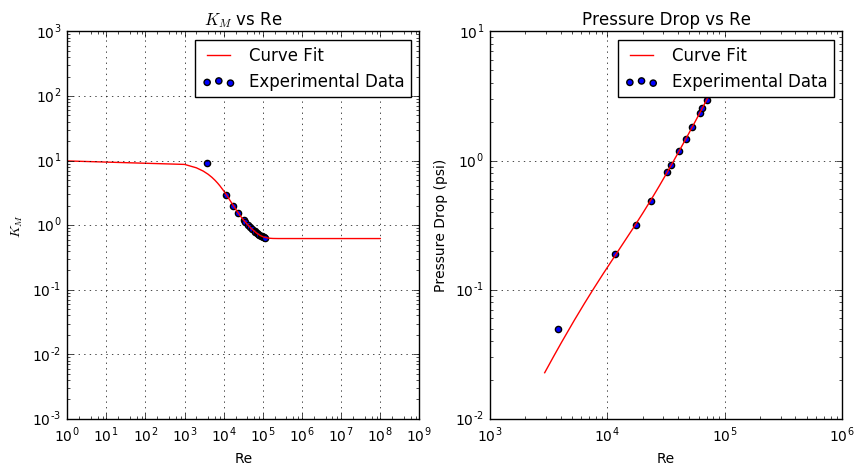

In [151]:
rho = 1000 # kg/m^3
mu = 1e-3 # Pa*s
ID = .0164338 # m
L = .966216 # m
n_bends = 2
angle_bend = 135 # deg
R = .0508 # m
m_dot = data['mdot_lb_min']
dp_psi_exp = data['dp_psi']

[dP_df, coefs] = generate_pd_df(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R)
m_dot_in = dP_df['mdot_lb_min']
A1 = coefs[0]
A2 = coefs[1]
A3 = coefs[2]
A4 = coefs[3]
A5 = coefs[4]
[ax1, ax2] = generate_dP_curve(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R, dP_df, A1, A2, A3, A4, A5)

### Implementing widgets to control $A_1$ - $A_5$

In [152]:
import ipywidgets as widgets
from ipywidgets import interact

In [153]:
def plot_new(a1,a2,a3,a4,a5):
    [dP_df, coefs] = generate_pd_df(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R)
    [ax1, ax2] = generate_dP_curve(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R, dP_df, A1, A2, A3, A4, A5)
    x_in = np.linspace(1, 1e8, 100000)
    ax1.plot(x_in,K_M(x_in, a1, a2, a3, a4, a5), 'g-', label='Adj Curve Fit')
    ax1.legend()
    
    [Re, dP_out] = plot_dP_adj(a1,a2,a3,a4,a5)
    ax2.plot(Re, dP_out, 'g-', label='Adj Curve Fit')
    ax2.legend(loc=4)

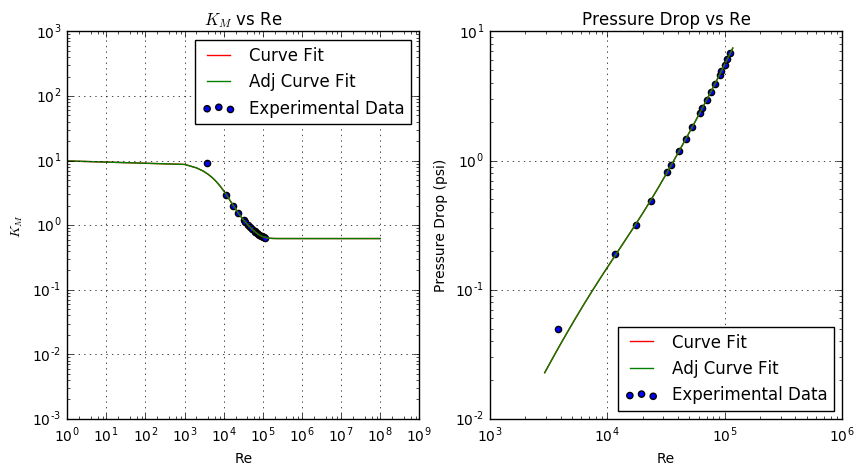

In [154]:
adj_plots = interact(plot_new,
             a1=widgets.BoundedFloatText(value=A1, description='A1'), 
             a2=widgets.BoundedFloatText(value=A2, description='A2'),
             a3=widgets.BoundedFloatText(value=A3, description='A3'), 
             a4=widgets.BoundedFloatText(value=A4, description='A4'), 
             a5=widgets.BoundedFloatText(value=A5, description='A5'))